In [2]:
import numpy as np
import torch
from torch import nn, BoolTensor, Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2

# Color Consistency Loss

## Define the Loss Layer

Inputs:

* Color prediction: $(B, C, H, W)$
* Segmentation masks: $(B, S, H, W)$

Sum of all 'True' values in the segmentation masks is $B*C*H*W$

Mask an prediction can be reshaped to $(B, C, H*W)$ resp. $(B, S, H*W)$

### Linear

Formula for one image:

$\hat{x}_a$: Mean along the masked a-channel of the prediction  
$\hat{x}_b$: Mean along the masked b-channel of the prediction

$$
\mathcal{L} = \frac{1}{N_s}\sum_{i=1}^{H*W}\hat{x}_a - x_{a,i} + \frac{1}{N_s}\sum_{i=1}^{H*W}\hat{x}_b - x_{b,i}
$$


### Square

Formula for one image:

$\hat{x}_a$: Mean along the masked a-channel of the prediction  
$\hat{x}_b$: Mean along the masked b-channel of the prediction

$$
\mathcal{L} = \frac{1}{N_s}\sum_{i=1}^{H*W}(\hat{x}_a - x_{a,i})^2 + \frac{1}{N_s}\sum_{i=1}^{H*W}(\hat{x}_b - x_{b,i})^2
$$

### Euclidean

### Square

Formula for one image:

$\hat{x}_a$: Mean along the masked a-channel of the prediction  
$\hat{x}_b$: Mean along the masked b-channel of the prediction

$$
\mathcal{L} = \frac{1}{N_s}\sum_{i=1}^{H*W}\sqrt{(\hat{x}_a - x_{a,i})^2 + (\hat{x}_b - x_{b,i})^2}
$$


In [3]:
class ColorConsistencyLoss(nn.Module):
    """
    in HSV color space, this loss would only touch the hue
    in RGB it touches all channels
    in Lab it uses a and b

    """

    def __init__(self, mode='square'):
        super(ColorConsistencyLoss, self).__init__()
        assert mode in ['square', 'euclidean', 'linear']
        self.mode = mode

    def forward(self, x: Tensor, segment_masks: BoolTensor) -> Tensor:
        # iterate over the segments
        # segments are masks, the AOI is true, everything else false
        loss = torch.zeros_like(x)
        for segment_mask in segment_masks:
            # segment has shape (H, W) and is a BoolTensor
            # parallel for all in batch dim
            # for each channel (a, b)
            segment = x[:, :, segment_mask].view(x.size()[0:2] + (-1,))
            x_mean = segment.mean(2)  # result has shape (N, 2)

            if self.mode == 'square':
                loss[:, :, segment_mask] = torch.square(segment - torch.unsqueeze(x_mean, -1))  # (N, C, len(segment))
            elif self.mode == 'euclidean':
                squared = torch.square(segment - torch.unsqueeze(x_mean, -1))  # (N, C, len(segment))
                loss[:, :, segment_mask] = torch.sqrt_(squared + 1e-8).sum(1)
            elif self.mode == 'linear':
                loss[:, :, segment_mask] = F.smooth_l1_loss(segment, torch.unsqueeze(x_mean, -1).expand_as(
                    segment))  # (N, C, len(segment))
        # return loss per pixel and channel on purpose for better debugging
        # return loss.mean()
        return loss

## Test

In [4]:
x = torch.tensor([[[[5, 3, 3],
                    [2, 1, 0],
                    [10, 0, 0]],
                   [[1, -1, -3],
                    [0, 0, 0],
                    [3, 0, 0]]]], dtype=torch.float, requires_grad=True)
segment_masks = [torch.tensor([[True, True, True],
                               [True, True, False],
                               [True, False, False]])]

loss = ColorConsistencyLoss('linear')(x, segment_masks)
loss = loss.mean()
print('Linear loss: ', loss.detach().numpy())
loss.backward()

non_squared = x.grad.clone().detach().numpy().reshape(1, 2, 9)

x.grad.zero_()

loss = ColorConsistencyLoss('square')(x, segment_masks)
loss = loss.mean()
print('Square loss: ', loss.detach().numpy())
assert loss == 4.0

loss.backward()

squared = x.grad.detach().numpy().reshape(1, 2, 9)

print('Gradients linear:')
print(non_squared[0, 0, :])
print(non_squared[0, 1, :])
print('Gradients square:')
print(squared[0, 0, :])
print(squared[0, 1, :])

Linear loss:  0.9444444
Square loss:  4.0
Gradients linear:
[ 0.07407408 -0.03703704 -0.03703704 -0.03703704 -0.03703704  0.
  0.07407408  0.          0.        ]
[ 0.05555556 -0.05555556 -0.05555556  0.          0.          0.
  0.05555556  0.          0.        ]
Gradients square:
[ 0.11111111 -0.11111111 -0.11111111 -0.22222222 -0.33333334  0.
  0.6666667   0.          0.        ]
[ 0.11111111 -0.11111111 -0.33333334  0.          0.          0.
  0.33333334  0.          0.        ]


## Plot Predictions in ab colorspace (2D)

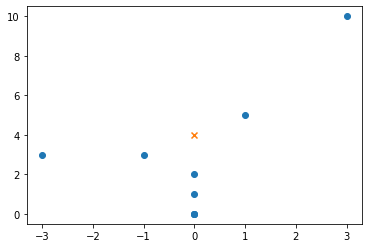

In [5]:
plt.scatter(x.detach().numpy().reshape(1, 2, 9)[:, 1, :], x.detach().numpy().reshape(1, 2, 9)[:, 0, :])
plt.scatter(0, 4, marker='x');

## Plot Gradients in ab colorspace

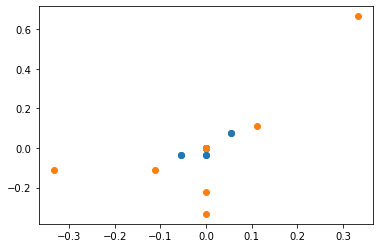

In [6]:
plt.scatter(non_squared[0, 1, :], non_squared[0, 0, :])
plt.scatter(squared[0, 1, :], squared[0, 0, :]);

## Load images

In [27]:
img = cv2.cvtColor(cv2.imread('resources/ILSVRC2012_val_00000015.JPEG'), cv2.COLOR_BGR2RGB)
pred = cv2.cvtColor(cv2.imread('resources/prediction-00014.jpg'), cv2.COLOR_BGR2RGB)
pred = pred[:, 2 * pred.shape[1] // 3:, :]
segment = cv2.imread('/mnt/data/datasets/Imagenet-SLIC-SEG100-COMP5-ITER10/val/ILSVRC2012_val_00000015.png')[:, :, 0]

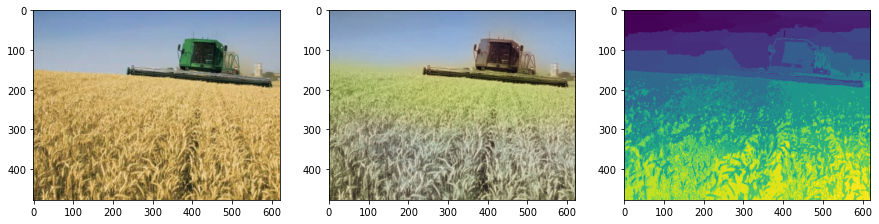

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].imshow(img)
ax[1].imshow(pred)
ax[2].imshow(segment)

## Extract segment masks

In [29]:
import torch
segment_masks = torch.nn.functional.one_hot(torch.from_numpy(segment).long()).permute(2, 0, 1).bool().numpy()

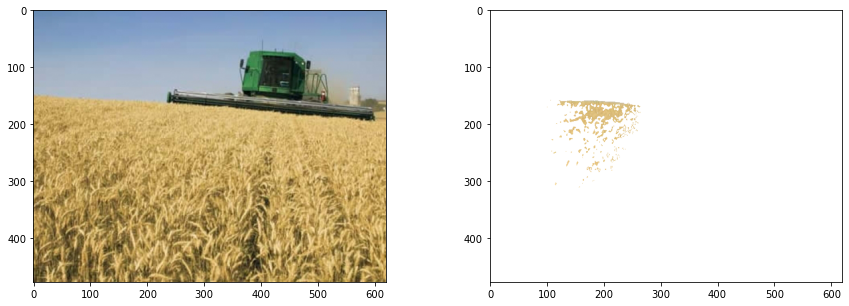

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
masked_img = img.copy()
plt.imshow(masked_img)
ax[0].imshow(masked_img)
masked_img[np.logical_not(segment_masks[40]), :] = 255
ax[1].imshow(masked_img)

## Example Loss on Groundtruth

Loss: 3.2642019


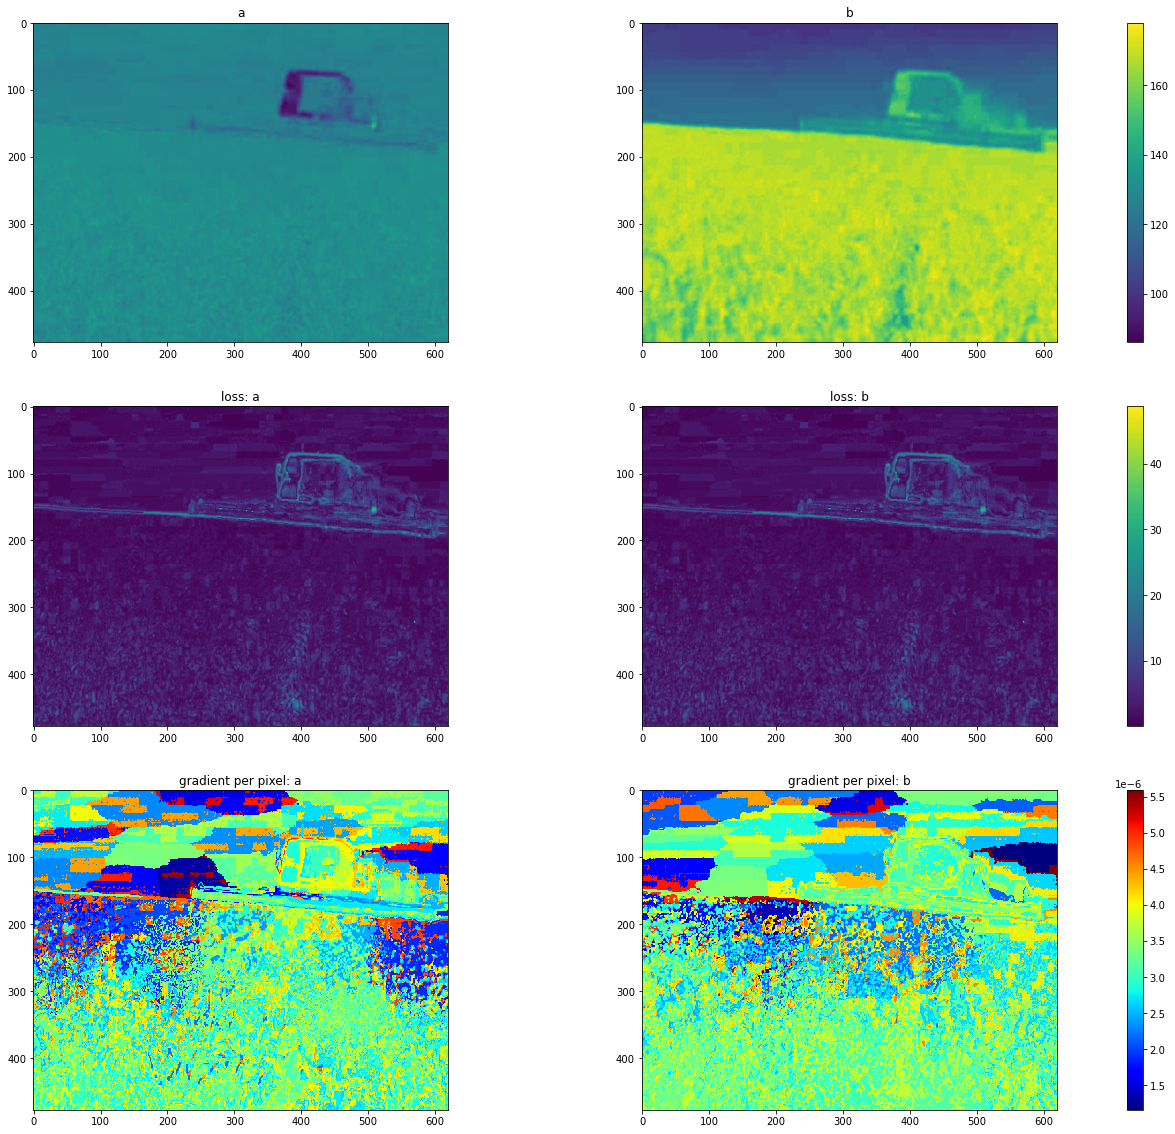

In [31]:
segment_masks_tensor = [torch.from_numpy(mask) for mask in segment_masks]
ab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)[:, :, 1:].transpose(2, 0, 1)

img_tensor = torch.from_numpy(ab).float().requires_grad_()
loss = ColorConsistencyLoss('euclidean')(torch.unsqueeze(img_tensor, 0), segment_masks_tensor)
np_loss = np.squeeze(loss.detach().numpy())

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(25, 20))
# ab
cb = ax[0, 0].imshow(ab[0, :, :], vmin=ab.min(), vmax=ab.max())
ax[0, 1].imshow(ab[1, :, :], vmin=ab.min(), vmax=ab.max())
fig.colorbar(cb, ax=ax[0])
ax[0, 0].set_title('a')
ax[0, 1].set_title('b')

# loss per pixel
cb = ax[1, 0].imshow(np_loss[0, :, :], vmin=np_loss.min(), vmax=np_loss.max())
ax[1, 1].imshow(np_loss[1, :, :], vmin=np_loss.min(), vmax=np_loss.max())
fig.colorbar(cb, ax=ax[1])
ax[1, 0].set_title('loss: a')
ax[1, 1].set_title('loss: b')

# mean + backward
loss = loss.mean()
print('Loss:', loss.detach().numpy())
loss.backward()

grads = np.abs(img_tensor.grad.detach().numpy())

# gradient
cb = ax[2, 0].imshow(grads[0, :, :], cmap='jet', interpolation='nearest', vmin=grads.min(), vmax=grads.max())
ax[2, 1].imshow(grads[1, :, :], cmap='jet', interpolation='nearest', vmin=grads.min(), vmax=grads.max())
fig.colorbar(cb, ax=ax[2])
ax[2, 0].set_title('gradient per pixel: a')
ax[2, 1].set_title('gradient per pixel: b');

## Example Loss on Prediction

Loss: 5.89645


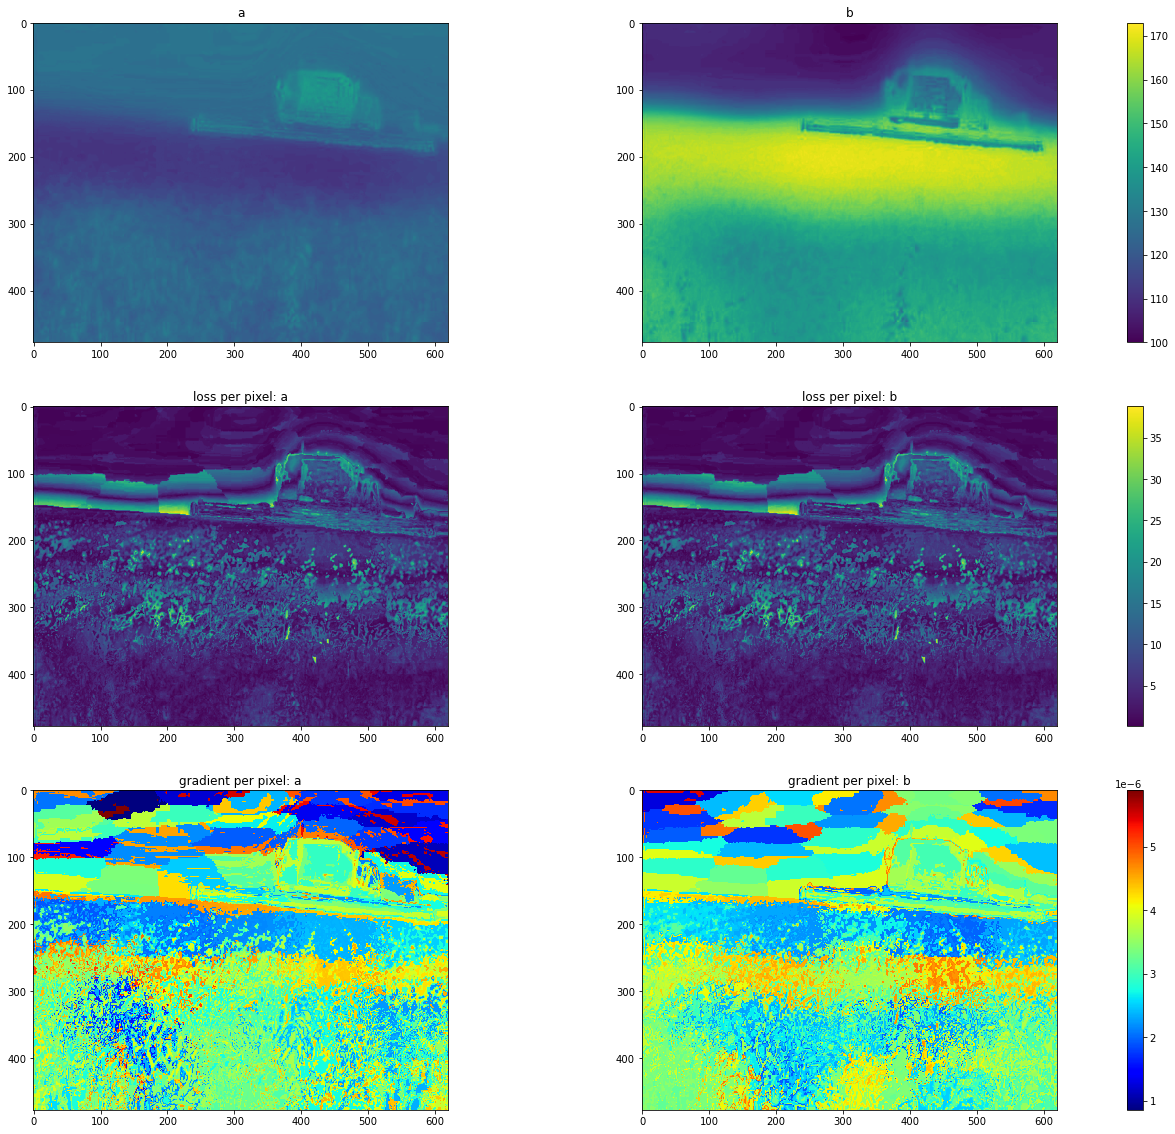

In [32]:
segment_masks_tensor = [torch.from_numpy(mask) for mask in segment_masks]
ab_pred = cv2.cvtColor(pred, cv2.COLOR_RGB2LAB)[:, :, 1:].transpose(2, 0, 1)

img_tensor = torch.from_numpy(ab_pred).float().requires_grad_()
loss = ColorConsistencyLoss('euclidean')(torch.unsqueeze(img_tensor, 0), segment_masks_tensor)
np_loss = np.squeeze(loss.detach().numpy())

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(25, 20))
# ab channels of the prediction
cb = ax[0, 0].imshow(ab_pred[0, :, :], vmin=ab_pred.min(), vmax=ab_pred.max())
ax[0, 1].imshow(ab_pred[1, :, :], vmin=ab_pred.min(), vmax=ab_pred.max())
fig.colorbar(cb, ax=ax[0])
ax[0, 0].set_title('a')
ax[0, 1].set_title('b')

# loss per pixel and channel
cb = ax[1, 0].imshow(np_loss[0, :, :], vmin=np_loss.min(), vmax=np_loss.max())
ax[1, 1].imshow(np_loss[1, :, :], vmin=np_loss.min(), vmax=np_loss.max())
fig.colorbar(cb, ax=ax[1])
ax[1, 0].set_title('loss per pixel: a')
ax[1, 1].set_title('loss per pixel: b')

# mean and backward
loss = loss.mean()
print('Loss:', loss.detach().numpy())
loss.backward()

grads = np.abs(img_tensor.grad.detach().numpy())

# gradients
cs = ax[2, 0].imshow(grads[0, :, :], cmap='jet', interpolation='nearest', vmin=grads.min(), vmax=grads.max())
fig.colorbar(cs, ax=ax[2])
ax[2, 1].imshow(grads[1, :, :], cmap='jet', interpolation='nearest', vmin=grads.min(), vmax=grads.max())
ax[2, 0].set_title('gradient per pixel: a')
ax[2, 1].set_title('gradient per pixel: b');